# Checkpoint #1

In [2]:
import numpy as np
from torch import nn
import torchani
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
import ANI1datatools.pyanitools as pya

In [4]:
# Set the HDF5 file containing the data
hdf5file = 'ANI-1_release/ani_gdb_s01.h5'

# Construct the data loader class
data = pya.anidataloader(hdf5file)
data_iter = data.__iter__()
# Print the species of the data set one by one


/global/homes/j/jamshedu/.local/perlmutter/pytorch1.9.0/lib/python3.8/site-packages/ANI1datatools/pyanitools.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.store = h5py.File(store_file)


In [5]:
mols = next(data_iter)
# Extract the data
P = mols['path']
X = mols['coordinates']
E = mols['energies']
S = mols['species']
sm = mols['smiles']

# Print the data
print("Path:   ", P)
print("  Smiles:      ","".join(sm))
print("  Symbols:     ", S)
print("  Coordinates: ", X.shape)
print("  Energies:    ", E.shape, "\n")

Path:    /gdb11_s01/gdb11_s01-0
  Smiles:       [H]C([H])([H])[H]
  Symbols:      ['C', 'H', 'H', 'H', 'H']
  Coordinates:  (5400, 5, 3)
  Energies:     (5400,) 



# Preliminary Information:

## Length of the coordinates is how many conformations there are for each molecule. This length is the same for final energies we need to predict. Ex. for water there are 1800 conformations and 1800 energies associated with them.

## Shape of the coordinates is rows x columns x array. Where each array is a coordinate value x, y, z. The rows correspond to each conformation and the columns correspond to each chemical species in the compound

## Working with the water molecule from s01 to show that the molecule can be read, train-test-split can be performed and batching occurs. Currently am calculating AEVs before conducting train-test-split, in the future may consider conducting train-test-split before calculating AEVs.

In [6]:
list_files_2 = ['ANI-1_release/ani_gdb_s01.h5']

data_set_X = []
y_energies = []

for i in list_files_2:
    hdf5file = i
    print(i)
    # Construct the data loader class
    data = pya.anidataloader(hdf5file)
    data_iter = data.__iter__()
    for mol in data_iter:  
        data_set_X.append({'species': mol['species'], 'coordinates': mol['coordinates']})
        y_energies.append(mol['energies'])

ANI-1_release/ani_gdb_s01.h5


In [7]:
data_set_X[0]

{'species': ['C', 'H', 'H', 'H', 'H'],
 'coordinates': array([[[-0.0034502 ,  0.01017081,  0.01938033],
         [-0.7954868 ,  0.5766599 , -0.5472012 ],
         [-0.39378393, -0.97992676,  0.2722862 ],
         [ 0.6344988 ,  0.4473651 ,  0.93568736],
         [ 0.59581804, -0.16517928, -0.8915708 ]],
 
        [[ 0.00311385, -0.02007288,  0.00282224],
         [-0.78331304,  0.7921426 , -0.26027855],
         [-0.45410746, -1.0295471 ,  0.31240797],
         [ 0.44713658,  0.63571125,  0.76770777],
         [ 0.7531731 , -0.1592813 , -0.85348135]],
 
        [[-0.0177954 , -0.02192003, -0.01129478],
         [-0.73020756,  0.6824338 , -0.30819252],
         [-0.382202  , -0.86773723,  0.3822439 ],
         [ 0.56933683,  0.50535196,  0.80417496],
         [ 0.75492465, -0.05902938, -0.74378157]],
 
        ...,
 
        [[ 0.00874467,  0.00214323, -0.00896647],
         [-0.85504687,  0.6273413 , -0.26081228],
         [-0.47105345, -0.9456285 ,  0.3252177 ],
         [ 0.48764503,

In [8]:
print(f'Length of final data set X is: {len(data_set_X)}')

Length of final data set X is: 3


## Each AEV is 384 elements long and corresponds to 1 atom of a molecule in 1 conformation.
## So for s01, where there are 3 molecules, 
## CH4 (5400 conformations, 5 aevs/conformation), NH3 (3600 conformations, 4 aevs/conformation), H20 (1800, 3 aevs/conformation)
## total aevs = 27,000, 14,400, 5400
## For Water the shape we should use is (1800, 3, 384), 1800 conformations for (3 x 384)

In [11]:
water = data_set_X[2]
water_energies = y_energies[2]
water['coordinates'].shape

(1800, 3, 3)

In [12]:
from functools import wraps
from time import time
from tqdm import tqdm

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

## Function to convert coordinates to AEV for a molecule, with an output shape of (num_conformations, num_atoms, 384), using torchani library is faster, see below.

In [48]:
@timing
def convert_coord_to_aev(coordinates, species):
    mapping={"H":0, "C":1, "N":2, "O":3}

    Rcr = 5.2
    EtaR = torch.tensor([16], dtype=torch.float)
    ShfR = torch.tensor([0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000, 3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250], dtype=torch.float)

    Rca = 3.5
    EtaA = torch.tensor([8], dtype=torch.float)
    ShfA = torch.tensor([0.900000,1.550000,2.200000,2.850000], dtype=torch.float)
    ShfZ = torch.tensor([0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243], dtype=torch.float)
    Zeta = torch.tensor([32], dtype=torch.float)

    num_species = 4

    elements = np.array([mapping[atom] for atom in species])
    atom_types = np.repeat(elements.reshape(1, len(elements)), len(coordinates), axis=0)
    #print(atom_types.shape)
    #print(coordinates.shape)
    #print(f'Test torch shape:{torch.tensor(atom_types, dtype=torch.int).size()}')
    #print(f'Test torch shape:{torch.tensor(coordinates, dtype=torch.float).size()}')

    AEVComputer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species)

    torch_tuple = (torch.tensor(atom_types, dtype=torch.long), torch.tensor(coordinates, dtype=torch.float))
    x = AEVComputer(torch_tuple)
    return x[1].detach().numpy()

In [39]:
water_aevs = convert_coord_to_aev(water['coordinates'], water['species'])

In [40]:
water_aevs.shape

(1800, 3, 384)

In [17]:
water_atoms = data_set_X[2]['species']
water_atoms

['O', 'H', 'H']

# Train Test Validation Splits

## Splitting the water_aevs (1800, 3, 384) and water_energies(1800,) into training, testing and validation sets below. These sets will be passed into our Trainer class to be further split into batches.

In [18]:
# setting seed with random_state = 42
mol_x_train, mol_x_test, mol_y_train, mol_y_test = train_test_split(water_aevs, water_energies, test_size=1/3, random_state=42)

In [19]:
print(f'Input shape for molecule training: {mol_x_train.shape}')
print(f'Output shape for molecule training: {mol_y_train.shape}')
print(f'Input shape for molecule testing: {mol_x_test.shape}')
print(f'Output shape for molecule testing: {mol_y_test.shape}')

Input shape for molecule training: (1200, 3, 384)
Output shape for molecule training: (1200,)
Input shape for molecule testing: (600, 3, 384)
Output shape for molecule testing: (600,)


In [20]:
# setting seed with random_state = 42
mol_x_train, mol_x_val, mol_y_train, mol_y_val = train_test_split(mol_x_train, mol_y_train, test_size=1/3, random_state=42)

In [21]:
print(f'Input shape for molecule training: {mol_x_train.shape}')
print(f'Output shape for molecule training: {mol_y_train.shape}')
print(f'Input shape for molecule validation: {mol_x_val.shape}')
print(f'Output shape for molecule validation: {mol_y_val.shape}')

Input shape for molecule training: (800, 3, 384)
Output shape for molecule training: (800,)
Input shape for molecule validation: (400, 3, 384)
Output shape for molecule validation: (400,)


In [22]:
# Look into splitting the molecule before into train test split and then calculate aevs and then send it into the training

## Creating a Preliminary Model

In [43]:
class ANI(nn.Module):
    def __init__(self):
        super(ANI, self).__init__()
        self.sub_nets = nn.ModuleDict({"C": ANI_sub(nn.Sequential(
                                                    nn.Linear(384,150),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.PReLU(),
                                                    nn.Linear(150, 50),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.PReLU(),
                                                    nn.Linear(50, 1)
                                                )), 
                                       "H": ANI_sub(nn.Sequential(
                                                    nn.Linear(384,150),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.PReLU(),
                                                    nn.Linear(150, 50),
                                                    nn.PReLU(),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.Linear(50, 1)
                                                )),                                         
                                       "N": ANI_sub(nn.Sequential(
                                                    nn.Linear(384,150),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.PReLU(),
                                                    nn.Linear(150, 50),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.PReLU(),
                                                    nn.Linear(50, 1)
                                                )), 
                                       "O": ANI_sub(nn.Sequential(
                                                    nn.Linear(384,150),
                                                    nn.PReLU(),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.Linear(150, 50),
                                                    nn.PReLU(),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.Linear(50, 1)
                                                ))})

    ## We cannot use ReLU functions because there are negative values in our AEVs and backpropogation will fail because
    ## the derivative of ReLU will be 0.
    def forward(self, aevs, atom_types):
        
        num_conformations, num_atoms, aev_vector_length = list(aevs.size())
        '''
        print(num_conformations)
        print(num_atoms)
        print(aev_vector_length)
        '''
        new_shape_aevs = aevs.view(num_atoms, num_conformations, aev_vector_length)
        #print(f'New shape is: {new_shape_aevs.size()}')
       
        atomic_energies = torch.zeros(num_conformations, 1)
        #print(f'New shape is: {atomic_energies.size()}')
        for i in range(len(atom_types)):
            #print(self.sub_nets[atom_types[i]](new_shape_aevs[i]))
            #print(f'Return shape is: {self.sub_nets[atom_types[i]](new_shape_aevs[i]).size()}')
            atomic_energies += self.sub_nets[atom_types[i]](new_shape_aevs[i])
            #atomic_energies.cat()
        # convert atomic energies to tensor and then sum up values in each row (sum all the columns for a row) 
        # to get an 1800 x 1 vector.
        #print((atomic_energies).shape)
        
        #atomic_energies = np.array(holding_list).T
        
        #print(f'Complete atomic energies: {atomic_energies}')
        #print(f'Complete atomic energies: {atomic_energies[0].shape}')
        
        #atomic_energies = torch.tensor(atomic_energies[0], dtype=torch.float)
        
        # dim = 1 to sum on columns
        #total_energies = torch.sum(atomic_energies,dim=1)
        #print(atomic_energies)
        return atomic_energies.view(num_conformations)

class ANI_sub(nn.Module):
    def __init__(self, architecture):
        super(ANI_sub, self).__init__()
        self.layers = architecture

    def forward(self, aev):
        #aev = torch.tensor(aev, dtype=torch.float)
        atomic_energy = self.layers(aev)
        #print(atomic_energy)
        return atomic_energy


## Trainer Class that will convert Training and Validation sets of our data into batches for use in our model

In [29]:
from torch.optim import SGD, Adam
from torch import nn
import torch
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size

    @timing
    def train(self, atom_types, inputs, outputs, val_inputs, val_outputs, draw_curve=True, early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures) should be 32x32.
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        #...
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.float)
                
        losses = []
        val_losses = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        loss_func = nn.MSELoss()
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            #epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                # self.model(aevs, atom_types)
                
                #print(batch_input.shape)
        
                batch_predictions = self.model(batch_input, atom_types)
                
                #print(batch_predictions.shape)

                #MSELoss here.
                loss = loss_func(batch_predictions, batch_output) 
                
                #print(loss)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss = loss + 0.00001 * l2_norm
                    #lambda is 1e-5 == 0.00001
                    
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ### Compute epoch_loss 

                epoch_loss += loss.detach().cpu().item() * batch_importance

            #print(val_inputs.shape)
            val_loss = self.evaluate(atom_types, val_inputs, val_outputs)
            if n_epoch % 10 ==0 and not silent:
                print("Epoch %d/%d - Loss: %.3f" % (n_epoch + 1, self.epoch, epoch_loss))
                print("              Val_loss: %.3f" % (val_loss))
                print("              Batch_size: %.3f" % (self.batch_size))
            losses.append(epoch_loss)
            val_losses.append(val_loss)
            '''
            xd = 0
            for param in self.model.parameters():
                print(f'Parameter {xd}: {param}')
                xd+=1
            '''    
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(self.epoch) + 1,losses,label='Training loss')
            plt.plot(np.arange(self.epoch) + 1,val_losses,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(atom_types)
            plt.legend()
        
        if early_stop:
            self.model.load_state_dict(weights)    
        
        return {"losses": losses, "val_losses": val_losses}
        
    def evaluate(self, atom_types, inputs, outputs, print_loss=False):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.float)
        
        loss_func = nn.MSELoss()
        
        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        #print(f"batch indices length = {len(batch_indices)}")
        #print(f"output length = {len(outputs)}")
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
                ### Compute prediction and loss###
                batch_predictions = self.model(batch_input, atom_types)
                #print(batch_predictions)
                #print(len(batch_input))
                #print(batch_importance)
                '''
                print(batch_predictions)
                print(batch_output)
                '''
                loss = loss_func(batch_predictions, batch_output)
                #print(loss)
                
            losses += loss.detach().cpu().item() * batch_importance
        if print_loss:
            print("Val Loss: %.3f" % losses, "Batch size: %.3f" % self.batch_size)
        return losses

In [30]:
ANI = ANI()

In [31]:
ANI_trainer = Trainer(ANI, "adam", 2e-3, 50, 128)

 12%|█▏        | 6/50 [00:00<00:00, 51.64it/s]

Epoch 1/50 - Loss: 5748.761
              Val_loss: 5662.833
              Batch_size: 128.000
Epoch 11/50 - Loss: 33.537
              Val_loss: 30.382
              Batch_size: 128.000


 60%|██████    | 30/50 [00:00<00:00, 52.05it/s]

Epoch 21/50 - Loss: 1.665
              Val_loss: 1.534
              Batch_size: 128.000
Epoch 31/50 - Loss: 1.045
              Val_loss: 0.910
              Batch_size: 128.000


Epoch 41/50 - Loss: 0.756
              Val_loss: 0.680
              Batch_size: 128.000
func:'train'  took: 0.9755 sec


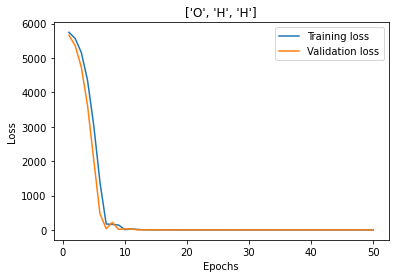

In [32]:
log=ANI_trainer.train(water_atoms, mol_x_train, mol_y_train, mol_x_val, mol_y_val)

In [26]:
log

{'losses': [5800.25408203125,
  5467.49689453125,
  4654.453398437499,
  3158.283974609375,
  1205.684072265625,
  87.92128143310549,
  317.03612426757815,
  71.50229290008546,
  49.784417724609376,
  49.86687286376953,
  14.125180931091307,
  22.11478225708008,
  11.158614501953124,
  11.220584106445314,
  10.315771408081055,
  8.148899841308594,
  7.383278102874756,
  7.28473222732544,
  6.604299640655517,
  5.642253589630126,
  5.526977844238281,
  4.610547256469727,
  4.460895195007324,
  4.0583260631561275,
  3.674419574737549,
  3.493509941101074,
  3.186716041564941,
  2.8892687606811527,
  2.8076209259033202,
  2.389150323867798,
  2.1149167823791504,
  2.112538471221924,
  1.8608088827133178,
  1.7603516054153443,
  1.5825294399261474,
  1.5030388545989992,
  1.3172003984451295,
  1.2320582628250123,
  1.1903484916687013,
  1.0365194129943847,
  1.0443460607528687,
  0.8955001211166381,
  0.8872990512847901,
  0.8187233424186706,
  0.7408372473716737,
  0.7419434547424316,
  0

## The model is now working with the training and validation error not getting any lower for water. They are also not diverging so we are not over-fitting yet, however we could be under fitting. Now we will attempt to train on all the molecules in the s01 dataset (contains methane, ammonia, and water).

# Checkpoint 2

func:'convert_coord_to_aev'  took: 0.0760 sec
['C', 'H', 'H', 'H', 'H']


  4%|▍         | 2/50 [00:00<00:03, 14.21it/s]

Epoch 1/50 - Loss: 1292.666
              Val_loss: 424.137
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:00<00:02, 14.68it/s]

Epoch 11/50 - Loss: 0.693
              Val_loss: 0.705
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:01<00:01, 14.68it/s]

Epoch 21/50 - Loss: 0.237
              Val_loss: 0.258
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:02<00:01, 14.62it/s]

Epoch 31/50 - Loss: 0.089
              Val_loss: 0.098
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:02<00:00, 14.46it/s]

Epoch 41/50 - Loss: 0.042
              Val_loss: 0.043
              Batch_size: 128.000


func:'train'  took: 3.4424 sec
func:'convert_coord_to_aev'  took: 0.0305 sec
['N', 'H', 'H', 'H']


  6%|▌         | 3/50 [00:00<00:02, 21.36it/s]

Epoch 1/50 - Loss: 946.268
              Val_loss: 21.794
              Batch_size: 128.000


 30%|███       | 15/50 [00:00<00:01, 21.29it/s]

Epoch 11/50 - Loss: 0.483
              Val_loss: 0.442
              Batch_size: 128.000


 48%|████▊     | 24/50 [00:01<00:01, 21.37it/s]

Epoch 21/50 - Loss: 0.250
              Val_loss: 0.260
              Batch_size: 128.000


 66%|██████▌   | 33/50 [00:01<00:00, 21.35it/s]

Epoch 31/50 - Loss: 0.206
              Val_loss: 0.198
              Batch_size: 128.000


 90%|█████████ | 45/50 [00:02<00:00, 21.33it/s]

Epoch 41/50 - Loss: 0.150
              Val_loss: 0.158
              Batch_size: 128.000


func:'train'  took: 2.3601 sec
func:'convert_coord_to_aev'  took: 0.0100 sec
['O', 'H', 'H']


  8%|▊         | 4/50 [00:00<00:01, 39.20it/s]

Epoch 1/50 - Loss: 3067.193
              Val_loss: 929.331
              Batch_size: 128.000


 32%|███▏      | 16/50 [00:00<00:00, 39.36it/s]

Epoch 11/50 - Loss: 2.182
              Val_loss: 0.658
              Batch_size: 128.000


 56%|█████▌    | 28/50 [00:00<00:00, 39.34it/s]

Epoch 21/50 - Loss: 0.272
              Val_loss: 0.238
              Batch_size: 128.000


 72%|███████▏  | 36/50 [00:00<00:00, 39.29it/s]

Epoch 31/50 - Loss: 0.234
              Val_loss: 0.212
              Batch_size: 128.000


 96%|█████████▌| 48/50 [00:01<00:00, 39.24it/s]

Epoch 41/50 - Loss: 0.203
              Val_loss: 0.193
              Batch_size: 128.000


func:'train'  took: 1.2903 sec


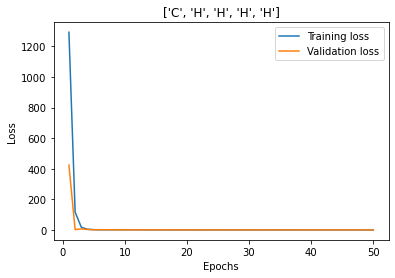

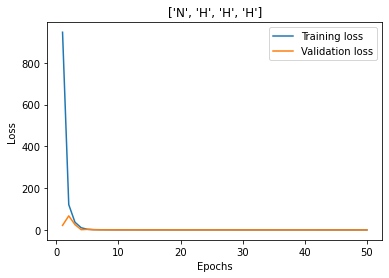

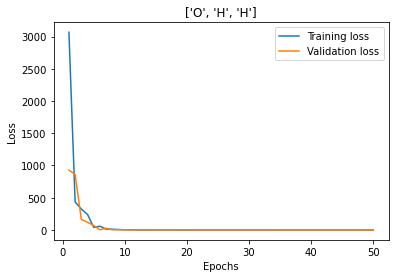

In [49]:
# The commented code below will get all the molecules for a h5 file in the ANI-1 dataset
'''
list_files_2 = ['ANI-1_release/ani_gdb_s01.h5']

data_set_X = []
y_energies = []

for i in list_files_2:
    hdf5file = i
    print(i)
    # Construct the data loader class
    data = pya.anidataloader(hdf5file)
    data_iter = data.__iter__()
    for mol in data_iter:  
        data_set_X.append({'species': mol['species'], 'coordinates': mol['coordinates']})
        y_energies.append(mol['energies'])
'''
# Intialize the model outside of the for loop which loops through the molecules in the data_set_X
ANI_1 = ANI()
ANI_trainer_1 = Trainer(ANI_1, "adam", 2e-3, 50, 128)

# Turn this into a function
for i in range(len(data_set_X)):
    mol = data_set_X[i]
    mol_energies = y_energies[i]
    mol_atoms = data_set_X[i]['species']

    mol_aevs = convert_coord_to_aev(mol['coordinates'], mol['species'])
    print(mol_atoms)

    mol_x_train, mol_x_test, mol_y_train, mol_y_test = train_test_split(mol_aevs, mol_energies, test_size=1/3, random_state=42)
    mol_x_train, mol_x_val, mol_y_train, mol_y_val = train_test_split(mol_x_train, mol_y_train, test_size=1/3, random_state=42)

    ANI_trainer_1.train(mol_atoms, mol_x_train, mol_y_train, mol_x_val, mol_y_val)    
    

In [50]:

list_files_2 = ['ANI-1_release/ani_gdb_s02.h5']

data_set_X_2 = []
y_energies_2 = []

for i in list_files_2:
    hdf5file = i
    print(i)
    # Construct the data loader class
    data = pya.anidataloader(hdf5file)
    data_iter = data.__iter__()
    for mol in data_iter:
        data_set_X_2.append({'species': mol['species'], 'coordinates': mol['coordinates']})
        y_energies_2.append(mol['energies'])


ANI-1_release/ani_gdb_s02.h5


/global/homes/j/jamshedu/.local/perlmutter/pytorch1.9.0/lib/python3.8/site-packages/ANI1datatools/pyanitools.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.store = h5py.File(store_file)


## Using the model from before to train on new molecules from the second h5 file.

func:'convert_coord_to_aev'  took: 0.5261 sec
['C', 'C', 'H', 'H', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:08,  5.77it/s]

Epoch 1/50 - Loss: 35038.684
              Val_loss: 1848.253
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:02<00:06,  5.78it/s]

Epoch 11/50 - Loss: 10.004
              Val_loss: 9.667
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:03<00:04,  5.78it/s]

Epoch 21/50 - Loss: 5.528
              Val_loss: 5.679
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:05<00:03,  5.78it/s]

Epoch 31/50 - Loss: 3.741
              Val_loss: 3.667
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:07<00:01,  5.79it/s]

Epoch 41/50 - Loss: 2.552
              Val_loss: 2.571
              Batch_size: 128.000


func:'train'  took: 8.6638 sec
func:'convert_coord_to_aev'  took: 0.2835 sec
['C', 'N', 'H', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:06,  7.52it/s]

Epoch 1/50 - Loss: 715.144
              Val_loss: 25.483
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:01<00:05,  7.32it/s]

Epoch 11/50 - Loss: 3.931
              Val_loss: 3.712
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:02<00:03,  7.44it/s]

Epoch 21/50 - Loss: 2.683
              Val_loss: 2.542
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:04<00:02,  7.48it/s]

Epoch 31/50 - Loss: 2.022
              Val_loss: 2.022
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:05<00:01,  7.49it/s]

Epoch 41/50 - Loss: 1.498
              Val_loss: 1.510
              Batch_size: 128.000


func:'train'  took: 6.7253 sec
func:'convert_coord_to_aev'  took: 0.0021 sec
['N', 'N']


 32%|███▏      | 16/50 [00:00<00:00, 157.97it/s]

Epoch 1/50 - Loss: 11231.500
              Val_loss: 11029.986
              Batch_size: 128.000
Epoch 11/50 - Loss: 1704.602
              Val_loss: 903.104
              Batch_size: 128.000
Epoch 21/50 - Loss: 12.774
              Val_loss: 60.938
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:00<00:00, 156.99it/s]

Epoch 31/50 - Loss: 19.117
              Val_loss: 9.317
              Batch_size: 128.000


Epoch 41/50 - Loss: 0.722
              Val_loss: 1.444
              Batch_size: 128.000
func:'train'  took: 0.3342 sec


func:'convert_coord_to_aev'  took: 0.0655 sec
['O', 'N', 'H', 'H', 'H']


  4%|▍         | 2/50 [00:00<00:04, 11.78it/s]

Epoch 1/50 - Loss: 396.844
              Val_loss: 163.195
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:00<00:02, 14.30it/s]

Epoch 11/50 - Loss: 1.134
              Val_loss: 1.113
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:01<00:01, 14.63it/s]

Epoch 21/50 - Loss: 0.672
              Val_loss: 0.752
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:02<00:01, 14.73it/s]

Epoch 31/50 - Loss: 0.514
              Val_loss: 0.613
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:02<00:00, 14.73it/s]

Epoch 41/50 - Loss: 0.411
              Val_loss: 0.512
              Batch_size: 128.000


func:'train'  took: 3.5217 sec
func:'convert_coord_to_aev'  took: 0.0084 sec
['O', 'N', 'H']


 12%|█▏        | 6/50 [00:00<00:00, 53.86it/s]

Epoch 1/50 - Loss: 2656.319
              Val_loss: 897.315
              Batch_size: 128.000
Epoch 11/50 - Loss: 9.880
              Val_loss: 2.302
              Batch_size: 128.000


 36%|███▌      | 18/50 [00:00<00:00, 54.26it/s]

Epoch 21/50 - Loss: 1.238
              Val_loss: 1.421
              Batch_size: 128.000


 60%|██████    | 30/50 [00:00<00:00, 54.33it/s]

Epoch 31/50 - Loss: 0.943
              Val_loss: 1.105
              Batch_size: 128.000


 72%|███████▏  | 36/50 [00:00<00:00, 54.22it/s]

Epoch 41/50 - Loss: 0.707
              Val_loss: 0.898
              Batch_size: 128.000


func:'train'  took: 0.9387 sec


func:'convert_coord_to_aev'  took: 0.1514 sec
['C', 'O', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:05,  9.76it/s]

Epoch 1/50 - Loss: 718.881
              Val_loss: 250.499
              Batch_size: 128.000


 26%|██▌       | 13/50 [00:01<00:03, 10.07it/s]

Epoch 11/50 - Loss: 3.547
              Val_loss: 3.576
              Batch_size: 128.000


 46%|████▌     | 23/50 [00:02<00:02, 10.10it/s]

Epoch 21/50 - Loss: 2.372
              Val_loss: 2.381
              Batch_size: 128.000


 66%|██████▌   | 33/50 [00:03<00:01, 10.10it/s]

Epoch 31/50 - Loss: 1.684
              Val_loss: 1.781
              Batch_size: 128.000


 86%|████████▌ | 43/50 [00:04<00:00, 10.12it/s]

Epoch 41/50 - Loss: 1.425
              Val_loss: 1.418
              Batch_size: 128.000


func:'train'  took: 4.9688 sec
func:'convert_coord_to_aev'  took: 0.1454 sec
['C', 'C', 'H', 'H', 'H', 'H']


  6%|▌         | 3/50 [00:00<00:04, 10.10it/s]

Epoch 1/50 - Loss: 1272.572
              Val_loss: 186.765
              Batch_size: 128.000


 26%|██▌       | 13/50 [00:01<00:03, 10.14it/s]

Epoch 11/50 - Loss: 0.571
              Val_loss: 0.591
              Batch_size: 128.000


 46%|████▌     | 23/50 [00:02<00:02, 10.17it/s]

Epoch 21/50 - Loss: 0.460
              Val_loss: 0.461
              Batch_size: 128.000


 66%|██████▌   | 33/50 [00:03<00:01, 10.18it/s]

Epoch 31/50 - Loss: 0.366
              Val_loss: 0.364
              Batch_size: 128.000


 86%|████████▌ | 43/50 [00:04<00:00, 10.18it/s]

Epoch 41/50 - Loss: 0.301
              Val_loss: 0.303
              Batch_size: 128.000


func:'train'  took: 4.9335 sec
func:'convert_coord_to_aev'  took: 0.0258 sec
['C', 'O', 'H', 'H']


  6%|▌         | 3/50 [00:00<00:02, 23.37it/s]

Epoch 1/50 - Loss: 5606.934
              Val_loss: 1552.987
              Batch_size: 128.000


 30%|███       | 15/50 [00:00<00:01, 24.18it/s]

Epoch 11/50 - Loss: 1.019
              Val_loss: 1.126
              Batch_size: 128.000


 48%|████▊     | 24/50 [00:00<00:01, 24.26it/s]

Epoch 21/50 - Loss: 0.948
              Val_loss: 1.019
              Batch_size: 128.000


 66%|██████▌   | 33/50 [00:01<00:00, 24.41it/s]

Epoch 31/50 - Loss: 0.853
              Val_loss: 0.927
              Batch_size: 128.000


 90%|█████████ | 45/50 [00:01<00:00, 24.53it/s]

Epoch 41/50 - Loss: 0.865
              Val_loss: 0.861
              Batch_size: 128.000


func:'train'  took: 2.0719 sec
func:'convert_coord_to_aev'  took: 0.0020 sec
['O', 'O']


 32%|███▏      | 16/50 [00:00<00:00, 159.49it/s]

Epoch 1/50 - Loss: 21250.766
              Val_loss: 21065.037
              Batch_size: 128.000
Epoch 11/50 - Loss: 251.784
              Val_loss: 575.068
              Batch_size: 128.000
Epoch 21/50 - Loss: 477.978
              Val_loss: 285.199
              Batch_size: 128.000
Epoch 31/50 - Loss: 2.165
              Val_loss: 13.142
              Batch_size: 128.000


Epoch 41/50 - Loss: 7.793
              Val_loss: 6.344
              Batch_size: 128.000
func:'train'  took: 0.3274 sec
func:'convert_coord_to_aev'  took: 0.0249 sec
['O', 'O', 'H', 'H']


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Loss: 1379.710
              Val_loss: 1290.150
              Batch_size: 128.000


 30%|███       | 15/50 [00:00<00:01, 25.08it/s]

Epoch 11/50 - Loss: 2.747
              Val_loss: 10.126
              Batch_size: 128.000


 48%|████▊     | 24/50 [00:00<00:01, 25.10it/s]

Epoch 21/50 - Loss: 1.767
              Val_loss: 9.363
              Batch_size: 128.000


 72%|███████▏  | 36/50 [00:01<00:00, 25.12it/s]

Epoch 31/50 - Loss: 1.240
              Val_loss: 8.939
              Batch_size: 128.000


 90%|█████████ | 45/50 [00:01<00:00, 25.15it/s]

Epoch 41/50 - Loss: 0.955
              Val_loss: 8.642
              Batch_size: 128.000


func:'train'  took: 2.0079 sec
func:'convert_coord_to_aev'  took: 0.0250 sec
['C', 'C', 'H', 'H']


  6%|▌         | 3/50 [00:00<00:01, 24.47it/s]

Epoch 1/50 - Loss: 245.409
              Val_loss: 175.867
              Batch_size: 128.000


 30%|███       | 15/50 [00:00<00:01, 24.89it/s]

Epoch 11/50 - Loss: 0.552
              Val_loss: 0.449
              Batch_size: 128.000


 48%|████▊     | 24/50 [00:00<00:01, 24.95it/s]

Epoch 21/50 - Loss: 0.375
              Val_loss: 0.372
              Batch_size: 128.000


 66%|██████▌   | 33/50 [00:01<00:00, 25.02it/s]

Epoch 31/50 - Loss: 0.345
              Val_loss: 0.321
              Batch_size: 128.000


 90%|█████████ | 45/50 [00:01<00:00, 24.99it/s]

Epoch 41/50 - Loss: 0.326
              Val_loss: 0.283
              Batch_size: 128.000


func:'train'  took: 2.0217 sec
func:'convert_coord_to_aev'  took: 0.1511 sec
['N', 'N', 'H', 'H', 'H', 'H']


  4%|▍         | 2/50 [00:00<00:04, 10.11it/s]

Epoch 1/50 - Loss: 32578.189
              Val_loss: 5383.498
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:01<00:03, 10.27it/s]

Epoch 11/50 - Loss: 5.346
              Val_loss: 5.120
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:02<00:02, 10.27it/s]

Epoch 21/50 - Loss: 2.328
              Val_loss: 2.106
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:03<00:01, 10.29it/s]

Epoch 31/50 - Loss: 1.438
              Val_loss: 1.350
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:04<00:00, 10.31it/s]

Epoch 41/50 - Loss: 1.165
              Val_loss: 1.073
              Batch_size: 128.000


func:'train'  took: 4.8785 sec
func:'convert_coord_to_aev'  took: 0.0256 sec
['N', 'N', 'H', 'H']


  6%|▌         | 3/50 [00:00<00:01, 24.29it/s]

Epoch 1/50 - Loss: 2420.609
              Val_loss: 348.183
              Batch_size: 128.000


 30%|███       | 15/50 [00:00<00:01, 24.96it/s]

Epoch 11/50 - Loss: 2.292
              Val_loss: 2.400
              Batch_size: 128.000


 48%|████▊     | 24/50 [00:00<00:01, 24.90it/s]

Epoch 21/50 - Loss: 1.664
              Val_loss: 1.924
              Batch_size: 128.000


 72%|███████▏  | 36/50 [00:01<00:00, 25.03it/s]

Epoch 31/50 - Loss: 1.609
              Val_loss: 1.552
              Batch_size: 128.000


 90%|█████████ | 45/50 [00:01<00:00, 24.99it/s]

Epoch 41/50 - Loss: 1.134
              Val_loss: 1.275
              Batch_size: 128.000


func:'train'  took: 2.0213 sec


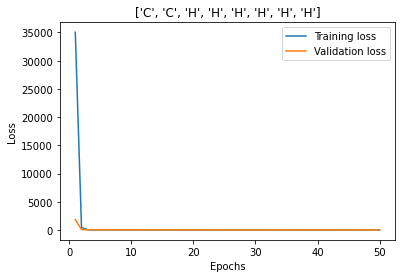

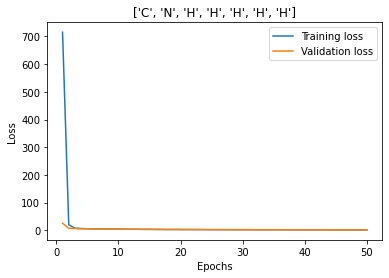

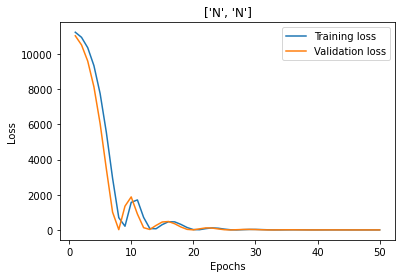

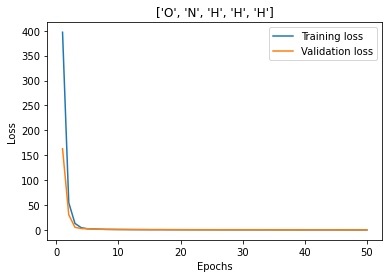

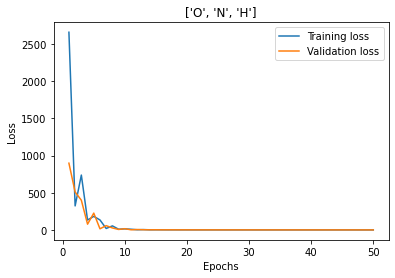

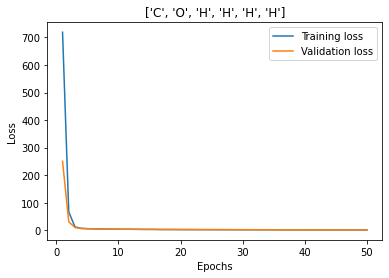

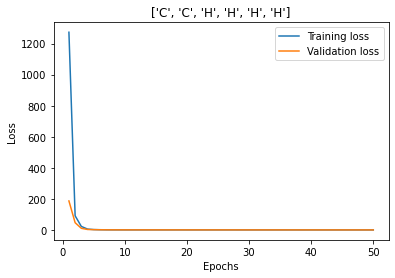

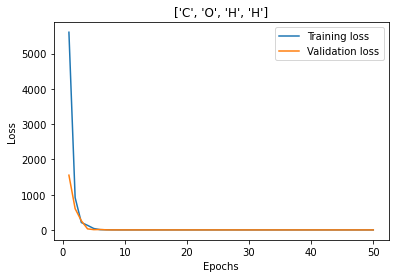

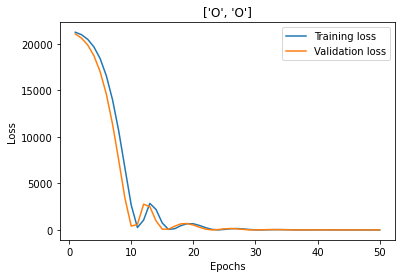

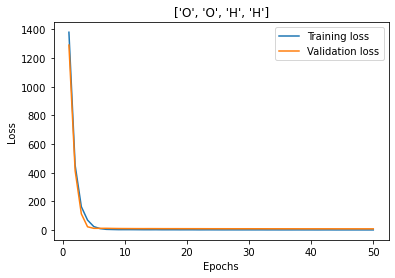

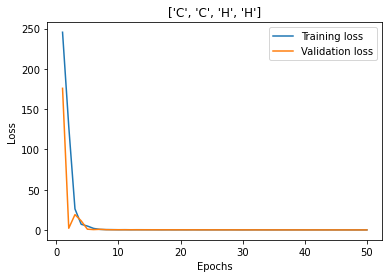

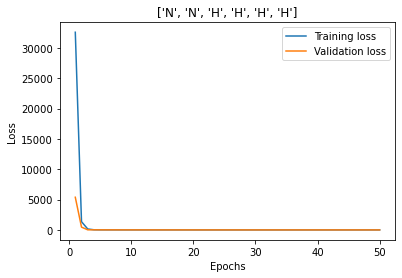

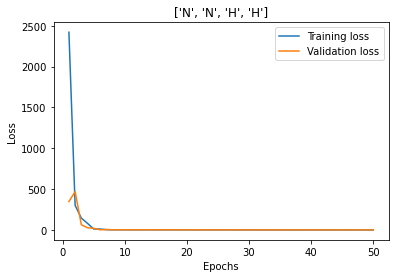

In [51]:
for i in range(len(data_set_X_2)):
    mol = data_set_X_2[i]
    mol_energies = y_energies_2[i]
    mol_atoms = data_set_X_2[i]['species']

    mol_aevs = convert_coord_to_aev(mol['coordinates'], mol['species'])
    print(mol_atoms)

    mol_x_train, mol_x_test, mol_y_train, mol_y_test = train_test_split(mol_aevs, mol_energies, test_size=1/3, random_state=42)
    mol_x_train, mol_x_val, mol_y_train, mol_y_val = train_test_split(mol_x_train, mol_y_train, test_size=1/3, random_state=42)

    ANI_trainer_1.train(mol_atoms, mol_x_train, mol_y_train, mol_x_val, mol_y_val)    

In [52]:

list_files_3 = ['ANI-1_release/ani_gdb_s03.h5']

data_set_X_3 = []
y_energies_3 = []

for i in list_files_3:
    hdf5file = i
    print(i)
    # Construct the data loader class
    data = pya.anidataloader(hdf5file)
    data_iter = data.__iter__()
    for mol in data_iter:
        data_set_X_3.append({'species': mol['species'], 'coordinates': mol['coordinates']})
        y_energies_3.append(mol['energies'])

ANI-1_release/ani_gdb_s03.h5


/global/homes/j/jamshedu/.local/perlmutter/pytorch1.9.0/lib/python3.8/site-packages/ANI1datatools/pyanitools.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.store = h5py.File(store_file)


## Train on the 3rd h5 file now.

func:'convert_coord_to_aev'  took: 1.7277 sec
['C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:15,  3.20it/s]

Epoch 1/50 - Loss: 703.424
              Val_loss: 4.004
              Batch_size: 128.000


 22%|██▏       | 11/50 [00:03<00:12,  3.22it/s]

Epoch 11/50 - Loss: 0.410
              Val_loss: 0.392
              Batch_size: 128.000


 42%|████▏     | 21/50 [00:06<00:09,  3.22it/s]

Epoch 21/50 - Loss: 0.300
              Val_loss: 0.291
              Batch_size: 128.000


 62%|██████▏   | 31/50 [00:09<00:05,  3.21it/s]

Epoch 31/50 - Loss: 0.245
              Val_loss: 0.230
              Batch_size: 128.000


 82%|████████▏ | 41/50 [00:12<00:02,  3.21it/s]

Epoch 41/50 - Loss: 0.175
              Val_loss: 0.166
              Batch_size: 128.000


func:'train'  took: 15.5658 sec
func:'convert_coord_to_aev'  took: 1.1830 sec
['C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:12,  3.79it/s]

Epoch 1/50 - Loss: 8.690
              Val_loss: 0.652
              Batch_size: 128.000


 22%|██▏       | 11/50 [00:02<00:10,  3.78it/s]

Epoch 11/50 - Loss: 0.193
              Val_loss: 0.199
              Batch_size: 128.000


 42%|████▏     | 21/50 [00:05<00:07,  3.79it/s]

Epoch 21/50 - Loss: 0.152
              Val_loss: 0.118
              Batch_size: 128.000


 62%|██████▏   | 31/50 [00:08<00:04,  3.81it/s]

Epoch 31/50 - Loss: 0.101
              Val_loss: 0.108
              Batch_size: 128.000


 82%|████████▏ | 41/50 [00:10<00:02,  3.80it/s]

Epoch 41/50 - Loss: 0.092
              Val_loss: 0.116
              Batch_size: 128.000


func:'train'  took: 13.2087 sec
func:'convert_coord_to_aev'  took: 0.1500 sec
['N', 'C', 'O', 'H', 'H', 'H']


  4%|▍         | 2/50 [00:00<00:04, 10.11it/s]

Epoch 1/50 - Loss: 18.375
              Val_loss: 4.312
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:01<00:03, 10.25it/s]

Epoch 11/50 - Loss: 0.172
              Val_loss: 0.150
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:02<00:02, 10.21it/s]

Epoch 21/50 - Loss: 0.100
              Val_loss: 0.092
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:03<00:01, 10.24it/s]

Epoch 31/50 - Loss: 0.087
              Val_loss: 0.067
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:04<00:00, 10.25it/s]

Epoch 41/50 - Loss: 0.059
              Val_loss: 0.053
              Batch_size: 128.000


func:'train'  took: 4.8980 sec
func:'convert_coord_to_aev'  took: 0.0696 sec
['O', 'C', 'O', 'H', 'H']


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Loss: 118.888
              Val_loss: 17.713
              Batch_size: 128.000


 28%|██▊       | 14/50 [00:00<00:02, 15.10it/s]

Epoch 11/50 - Loss: 0.124
              Val_loss: 0.309
              Batch_size: 128.000


 48%|████▊     | 24/50 [00:01<00:01, 15.11it/s]

Epoch 21/50 - Loss: 0.091
              Val_loss: 0.281
              Batch_size: 128.000


 68%|██████▊   | 34/50 [00:02<00:01, 15.13it/s]

Epoch 31/50 - Loss: 0.078
              Val_loss: 0.279
              Batch_size: 128.000


 88%|████████▊ | 44/50 [00:02<00:00, 15.12it/s]

Epoch 41/50 - Loss: 0.063
              Val_loss: 0.278
              Batch_size: 128.000


func:'train'  took: 3.3288 sec
func:'convert_coord_to_aev'  took: 0.2615 sec
['N', 'N', 'C', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:06,  7.65it/s]

Epoch 1/50 - Loss: 208.978
              Val_loss: 2.513
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:01<00:04,  7.69it/s]

Epoch 11/50 - Loss: 0.185
              Val_loss: 0.175
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:02<00:03,  7.68it/s]

Epoch 21/50 - Loss: 0.086
              Val_loss: 0.098
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:04<00:02,  7.68it/s]

Epoch 31/50 - Loss: 0.064
              Val_loss: 0.078
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:05<00:01,  7.68it/s]

Epoch 41/50 - Loss: 0.054
              Val_loss: 0.068
              Batch_size: 128.000


func:'train'  took: 6.5198 sec
func:'convert_coord_to_aev'  took: 0.1449 sec
['O', 'N', 'C', 'H', 'H', 'H']


  4%|▍         | 2/50 [00:00<00:04,  9.83it/s]

Epoch 1/50 - Loss: 12.988
              Val_loss: 5.128
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:01<00:03, 10.30it/s]

Epoch 11/50 - Loss: 0.070
              Val_loss: 0.058
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:02<00:02, 10.31it/s]

Epoch 21/50 - Loss: 0.041
              Val_loss: 0.036
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:03<00:01, 10.33it/s]

Epoch 31/50 - Loss: 0.036
              Val_loss: 0.029
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:04<00:00, 10.34it/s]

Epoch 41/50 - Loss: 0.030
              Val_loss: 0.026
              Batch_size: 128.000


func:'train'  took: 4.8679 sec
func:'convert_coord_to_aev'  took: 0.2207 sec
['C', 'C', 'C', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:06,  7.31it/s]

Epoch 1/50 - Loss: 224.835
              Val_loss: 27.145
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:01<00:04,  7.69it/s]

Epoch 11/50 - Loss: 0.173
              Val_loss: 0.184
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:02<00:03,  7.71it/s]

Epoch 21/50 - Loss: 0.133
              Val_loss: 0.137
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:04<00:02,  7.65it/s]

Epoch 31/50 - Loss: 0.117
              Val_loss: 0.121
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:05<00:01,  7.66it/s]

Epoch 41/50 - Loss: 0.101
              Val_loss: 0.105
              Batch_size: 128.000


func:'train'  took: 6.5369 sec
func:'convert_coord_to_aev'  took: 0.8783 sec
['C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:10,  4.67it/s]

Epoch 1/50 - Loss: 258.845
              Val_loss: 7.706
              Batch_size: 128.000


 22%|██▏       | 11/50 [00:02<00:08,  4.72it/s]

Epoch 11/50 - Loss: 0.102
              Val_loss: 0.094
              Batch_size: 128.000


 42%|████▏     | 21/50 [00:04<00:06,  4.73it/s]

Epoch 21/50 - Loss: 0.073
              Val_loss: 0.066
              Batch_size: 128.000


 62%|██████▏   | 31/50 [00:06<00:04,  4.74it/s]

Epoch 31/50 - Loss: 0.049
              Val_loss: 0.049
              Batch_size: 128.000


 82%|████████▏ | 41/50 [00:08<00:01,  4.75it/s]

Epoch 41/50 - Loss: 0.038
              Val_loss: 0.035
              Batch_size: 128.000


func:'train'  took: 10.5878 sec
func:'convert_coord_to_aev'  took: 0.5023 sec
['C', 'C', 'N', 'H', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:08,  5.77it/s]

Epoch 1/50 - Loss: 20.124
              Val_loss: 4.955
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:02<00:06,  5.91it/s]

Epoch 11/50 - Loss: 0.068
              Val_loss: 0.063
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:03<00:04,  5.91it/s]

Epoch 21/50 - Loss: 0.047
              Val_loss: 0.044
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:05<00:03,  5.91it/s]

Epoch 31/50 - Loss: 0.035
              Val_loss: 0.033
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:07<00:01,  5.92it/s]

Epoch 41/50 - Loss: 0.027
              Val_loss: 0.027
              Batch_size: 128.000


func:'train'  took: 8.4974 sec
func:'convert_coord_to_aev'  took: 0.2868 sec
['C', 'C', 'O', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:07,  6.90it/s]

Epoch 1/50 - Loss: 66.045
              Val_loss: 15.248
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:01<00:05,  7.55it/s]

Epoch 11/50 - Loss: 0.087
              Val_loss: 0.084
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:02<00:03,  7.64it/s]

Epoch 21/50 - Loss: 0.055
              Val_loss: 0.051
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:04<00:02,  7.64it/s]

Epoch 31/50 - Loss: 0.041
              Val_loss: 0.037
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:05<00:01,  7.66it/s]

Epoch 41/50 - Loss: 0.033
              Val_loss: 0.030
              Batch_size: 128.000


func:'train'  took: 6.5879 sec
func:'convert_coord_to_aev'  took: 0.0257 sec
['O', 'N', 'O', 'H']


  6%|▌         | 3/50 [00:00<00:01, 25.30it/s]

Epoch 1/50 - Loss: 637.202
              Val_loss: 428.703
              Batch_size: 128.000


 30%|███       | 15/50 [00:00<00:01, 25.43it/s]

Epoch 11/50 - Loss: 0.326
              Val_loss: 0.295
              Batch_size: 128.000


 48%|████▊     | 24/50 [00:00<00:01, 25.33it/s]

Epoch 21/50 - Loss: 0.206
              Val_loss: 0.206
              Batch_size: 128.000


 72%|███████▏  | 36/50 [00:01<00:00, 25.35it/s]

Epoch 31/50 - Loss: 0.146
              Val_loss: 0.164
              Batch_size: 128.000


 90%|█████████ | 45/50 [00:01<00:00, 25.32it/s]

Epoch 41/50 - Loss: 0.120
              Val_loss: 0.138
              Batch_size: 128.000


func:'train'  took: 1.9894 sec
func:'convert_coord_to_aev'  took: 0.0673 sec
['O', 'O', 'O', 'H', 'H']


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Loss: 359.831
              Val_loss: 5.659
              Batch_size: 128.000


 28%|██▊       | 14/50 [00:00<00:02, 15.20it/s]

Epoch 11/50 - Loss: 0.394
              Val_loss: 0.433
              Batch_size: 128.000


 48%|████▊     | 24/50 [00:01<00:01, 15.13it/s]

Epoch 21/50 - Loss: 0.289
              Val_loss: 0.323
              Batch_size: 128.000


 68%|██████▊   | 34/50 [00:02<00:01, 15.20it/s]

Epoch 31/50 - Loss: 0.206
              Val_loss: 0.241
              Batch_size: 128.000


 88%|████████▊ | 44/50 [00:02<00:00, 15.18it/s]

Epoch 41/50 - Loss: 0.164
              Val_loss: 0.200
              Batch_size: 128.000


func:'train'  took: 3.3144 sec
func:'convert_coord_to_aev'  took: 0.8398 sec
['C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:10,  4.56it/s]

Epoch 1/50 - Loss: 179.464
              Val_loss: 6.240
              Batch_size: 128.000


 22%|██▏       | 11/50 [00:02<00:08,  4.62it/s]

Epoch 11/50 - Loss: 0.411
              Val_loss: 0.445
              Batch_size: 128.000


 42%|████▏     | 21/50 [00:04<00:06,  4.62it/s]

Epoch 21/50 - Loss: 0.204
              Val_loss: 0.232
              Batch_size: 128.000


 62%|██████▏   | 31/50 [00:06<00:04,  4.62it/s]

Epoch 31/50 - Loss: 0.147
              Val_loss: 0.151
              Batch_size: 128.000


 82%|████████▏ | 41/50 [00:08<00:01,  4.63it/s]

Epoch 41/50 - Loss: 0.111
              Val_loss: 0.118
              Batch_size: 128.000


func:'train'  took: 10.8509 sec
func:'convert_coord_to_aev'  took: 1.1554 sec
['C', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:13,  3.67it/s]

Epoch 1/50 - Loss: 30.862
              Val_loss: 0.779
              Batch_size: 128.000


 22%|██▏       | 11/50 [00:02<00:10,  3.81it/s]

Epoch 11/50 - Loss: 0.087
              Val_loss: 0.080
              Batch_size: 128.000


 42%|████▏     | 21/50 [00:05<00:07,  3.82it/s]

Epoch 21/50 - Loss: 0.054
              Val_loss: 0.052
              Batch_size: 128.000


 62%|██████▏   | 31/50 [00:08<00:04,  3.83it/s]

Epoch 31/50 - Loss: 0.048
              Val_loss: 0.038
              Batch_size: 128.000


 82%|████████▏ | 41/50 [00:10<00:02,  3.82it/s]

Epoch 41/50 - Loss: 0.037
              Val_loss: 0.031
              Batch_size: 128.000


func:'train'  took: 13.1445 sec
func:'convert_coord_to_aev'  took: 0.7144 sec
['C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:10,  4.61it/s]

Epoch 1/50 - Loss: 3.367
              Val_loss: 1.131
              Batch_size: 128.000


 22%|██▏       | 11/50 [00:02<00:08,  4.63it/s]

Epoch 11/50 - Loss: 0.058
              Val_loss: 0.103
              Batch_size: 128.000


 42%|████▏     | 21/50 [00:04<00:06,  4.67it/s]

Epoch 21/50 - Loss: 0.034
              Val_loss: 0.062
              Batch_size: 128.000


 62%|██████▏   | 31/50 [00:06<00:04,  4.66it/s]

Epoch 31/50 - Loss: 0.029
              Val_loss: 0.044
              Batch_size: 128.000


 82%|████████▏ | 41/50 [00:08<00:01,  4.65it/s]

Epoch 41/50 - Loss: 0.023
              Val_loss: 0.036
              Batch_size: 128.000


func:'train'  took: 10.7730 sec
func:'convert_coord_to_aev'  took: 0.7193 sec
['C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:10,  4.69it/s]

Epoch 1/50 - Loss: 157.751
              Val_loss: 3.867
              Batch_size: 128.000


 22%|██▏       | 11/50 [00:02<00:08,  4.66it/s]

Epoch 11/50 - Loss: 0.118
              Val_loss: 0.114
              Batch_size: 128.000


 42%|████▏     | 21/50 [00:04<00:06,  4.67it/s]

Epoch 21/50 - Loss: 0.076
              Val_loss: 0.066
              Batch_size: 128.000


 62%|██████▏   | 31/50 [00:06<00:04,  4.67it/s]

Epoch 31/50 - Loss: 0.055
              Val_loss: 0.061
              Batch_size: 128.000


 82%|████████▏ | 41/50 [00:08<00:01,  4.68it/s]

Epoch 41/50 - Loss: 0.046
              Val_loss: 0.039
              Batch_size: 128.000


func:'train'  took: 10.8128 sec
func:'convert_coord_to_aev'  took: 0.2768 sec
['C', 'C', 'O', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:06,  7.54it/s]

Epoch 1/50 - Loss: 10.362
              Val_loss: 1.900
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:01<00:04,  7.60it/s]

Epoch 11/50 - Loss: 0.072
              Val_loss: 0.072
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:02<00:03,  7.58it/s]

Epoch 21/50 - Loss: 0.044
              Val_loss: 0.048
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:04<00:02,  7.59it/s]

Epoch 31/50 - Loss: 0.035
              Val_loss: 0.036
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:05<00:01,  7.61it/s]

Epoch 41/50 - Loss: 0.028
              Val_loss: 0.028
              Batch_size: 128.000


func:'train'  took: 6.5982 sec
func:'convert_coord_to_aev'  took: 0.0083 sec
['O', 'C', 'O']


 12%|█▏        | 6/50 [00:00<00:00, 55.65it/s]

Epoch 1/50 - Loss: 961.149
              Val_loss: 504.447
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:00<00:00, 55.76it/s]

Epoch 11/50 - Loss: 4.490
              Val_loss: 0.454
              Batch_size: 128.000


 36%|███▌      | 18/50 [00:00<00:00, 55.87it/s]

Epoch 21/50 - Loss: 0.363
              Val_loss: 0.382
              Batch_size: 128.000


 60%|██████    | 30/50 [00:00<00:00, 56.02it/s]

Epoch 31/50 - Loss: 0.305
              Val_loss: 0.311
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:00<00:00, 55.92it/s]

Epoch 41/50 - Loss: 0.263
              Val_loss: 0.268
              Batch_size: 128.000


func:'train'  took: 0.9104 sec


func:'convert_coord_to_aev'  took: 0.1429 sec
['C', 'C', 'N', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:05,  9.34it/s]

Epoch 1/50 - Loss: 32.999
              Val_loss: 7.682
              Batch_size: 128.000


 26%|██▌       | 13/50 [00:01<00:03, 10.38it/s]

Epoch 11/50 - Loss: 0.059
              Val_loss: 0.059
              Batch_size: 128.000


 46%|████▌     | 23/50 [00:02<00:02, 10.42it/s]

Epoch 21/50 - Loss: 0.029
              Val_loss: 0.030
              Batch_size: 128.000


 66%|██████▌   | 33/50 [00:03<00:01, 10.42it/s]

Epoch 31/50 - Loss: 0.019
              Val_loss: 0.018
              Batch_size: 128.000


 86%|████████▌ | 43/50 [00:04<00:00, 10.42it/s]

Epoch 41/50 - Loss: 0.015
              Val_loss: 0.014
              Batch_size: 128.000


func:'train'  took: 4.8293 sec
func:'convert_coord_to_aev'  took: 0.2708 sec
['N', 'C', 'N', 'H', 'H', 'H', 'H']


  2%|▏         | 1/50 [00:00<00:06,  7.57it/s]

Epoch 1/50 - Loss: 58.864
              Val_loss: 0.783
              Batch_size: 128.000


 24%|██▍       | 12/50 [00:01<00:04,  7.65it/s]

Epoch 11/50 - Loss: 0.090
              Val_loss: 0.298
              Batch_size: 128.000


 44%|████▍     | 22/50 [00:02<00:03,  7.63it/s]

Epoch 21/50 - Loss: 0.066
              Val_loss: 0.261
              Batch_size: 128.000


 64%|██████▍   | 32/50 [00:04<00:02,  7.64it/s]

Epoch 31/50 - Loss: 0.046
              Val_loss: 0.225
              Batch_size: 128.000


 84%|████████▍ | 42/50 [00:05<00:01,  7.66it/s]

Epoch 41/50 - Loss: 0.034
              Val_loss: 0.203
              Batch_size: 128.000


func:'train'  took: 6.5551 sec


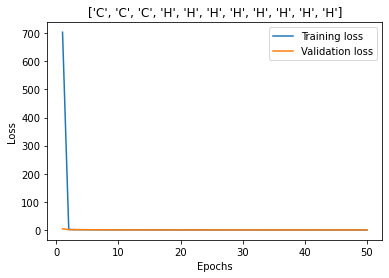

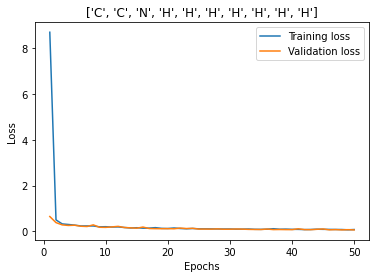

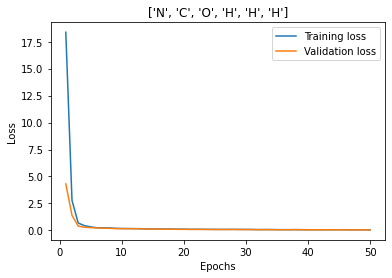

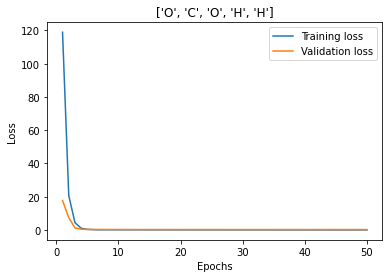

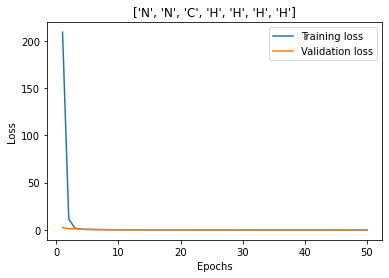

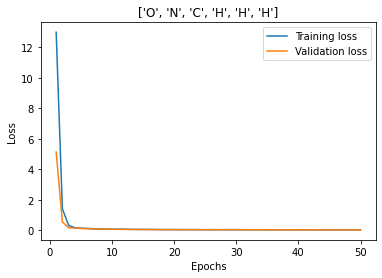

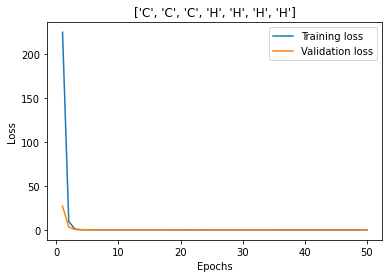

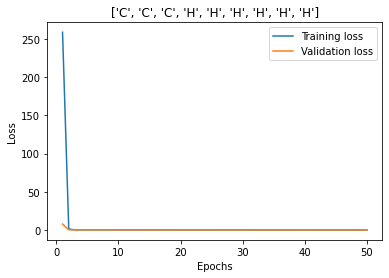

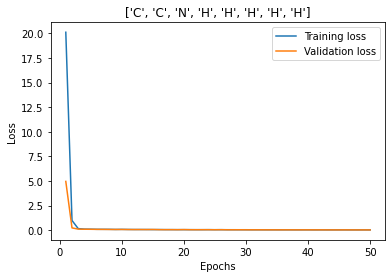

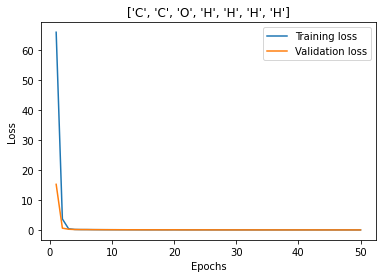

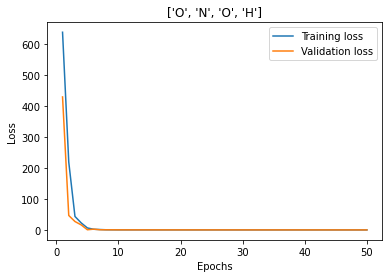

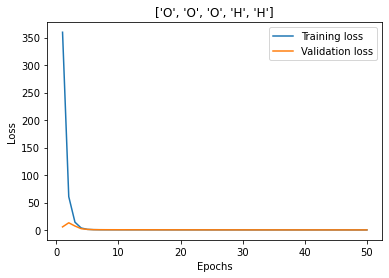

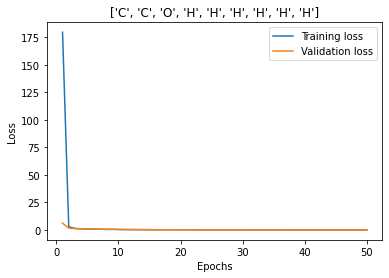

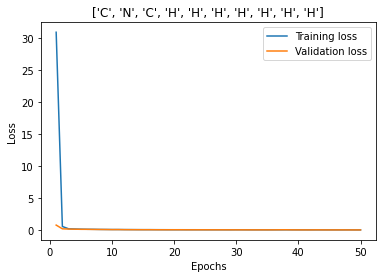

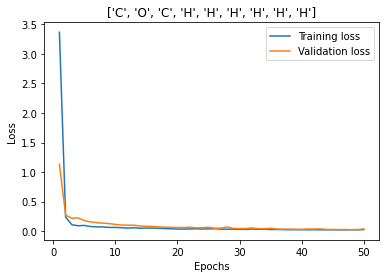

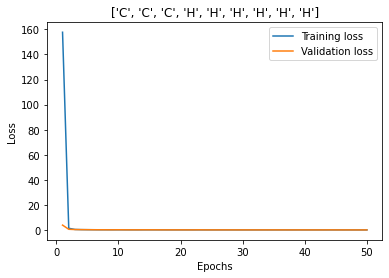

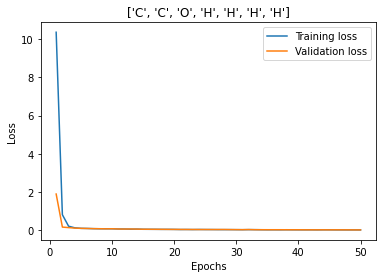

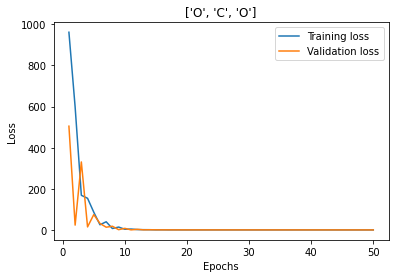

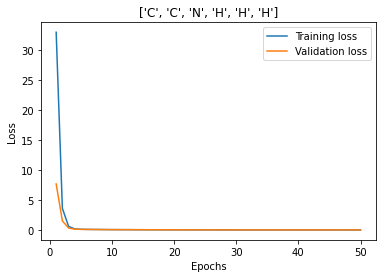

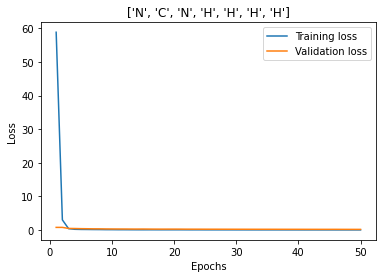

In [54]:
for i in range(len(data_set_X_3)):
    mol = data_set_X_3[i]
    mol_energies = y_energies_3[i]
    mol_atoms = data_set_X_3[i]['species']

    mol_aevs = convert_coord_to_aev(mol['coordinates'], mol['species'])
    print(mol_atoms)

    mol_x_train, mol_x_test, mol_y_train, mol_y_test = train_test_split(mol_aevs, mol_energies, test_size=1/3, random_state=42)
    mol_x_train, mol_x_val, mol_y_train, mol_y_val = train_test_split(mol_x_train, mol_y_train, test_size=1/3, random_state=42)

    ANI_trainer_1.train(mol_atoms, mol_x_train, mol_y_train, mol_x_val, mol_y_val)    